In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from matplotlib import pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')
print(train.shape)
X_a = train.drop(['id', 'target'], axis=1)
y_a = train['target']
X_test = test.drop(['id'], axis=1)
# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

['train.csv', 'sample_submission.csv', 'test.csv']
(250, 302)


Version two uses hyperparameters found by skopt search, let's see how it performs.

C=10 made no sense for linear regression, no idea what was wrong with the search that it gave me that as the answer though.

In [2]:
from sklearn.model_selection import train_test_split as ttsplit
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from tqdm import trange
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

nbc = GaussianNB()
nbc.fit(X_a, y_a)
sub.target = nbc.predict_proba(X_test)
sub.to_csv("submission.csv", index=False)


In [3]:
param = {'objective':'binary:logistic', 'eval_metric':['auc'], 'eta':0.015, 'max_depth':1, 'colsample_bytree':1, 'subsample':0.5, 'n_estimators':30, 'tree_method': 'gpu_hist', 'verbose':0
        }

num_round = 100

In [4]:
scoresa = []
scoresg = []
scores1 = []
scores2 = []
scores3 = []
scores4 = []
scores5 = []
precision = 10
for i in trange(500):
    X_train, X_val, y_train, y_val = ttsplit(X_a, y_a, test_size = 0.2)
#    knc = KNeighborsClassifier(n_neighbors=100, weights='distance')
#    knc.fit(X_train, y_train)
#    pred1 = knc.predict_proba(X_val)[:,1]
#    scores1+=[roc_auc_score(y_val, pred1)]

    nbc = GaussianNB()
    nbc.fit(X_train, y_train)
    pred2 = nbc.predict_proba(X_val)[:,1]
    scores2+=[roc_auc_score(y_val, pred2)]
    
    lr = LogisticRegression(solver = 'liblinear', C = .1, penalty = 'l1')
    lr.fit(X_train, y_train)
    pred3 = lr.predict_proba(X_val)[:,1]
    scores3+=[roc_auc_score(y_val, pred3)]
    
#    ab = AdaBoostClassifier(base_estimator=None, n_estimators=3, learning_rate=1.0)
#    ab.fit(X_train, y_train)
#    pred4 = ab.predict_proba(X_val)[:,1]
#    scores4+=[roc_auc_score(y_val, pred4)]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    evallist = [ (dtrain, 'train'), (dval, 'eval')]
    bst1 = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10, verbose_eval = False)
    pred5 = bst1.predict(xgb.DMatrix(X_val), ntree_limit=bst1.best_ntree_limit)
    scores5+=[roc_auc_score(y_val, pred5)]
    
    generalA = np.zeros((precision,precision)) #all possible arithmetic means
    for j in range(precision):
        for k in range(precision-j):
            generalA[j,k] = ( roc_auc_score(y_val,( (pred2*j+pred5*k+pred3*(precision-j-k))/precision )))

    scoresa+=[generalA]
    

print(np.average(np.array(scores2)),np.average(np.array(scores5)),np.average(np.array(scores3)))

100%|██████████| 500/500 [01:18<00:00,  6.46it/s]

0.7320484419244824 0.7464131909874508 0.7880944658765843


[[0.95236165 0.96849242 0.98332632 1.00236587 1.028396   1.06559851
  1.10752682 1.13938098 1.15167401 1.07380012]
 [1.30548179 1.34081685 1.37783801 1.41415831 1.45322942 1.4836449
  1.47786269 1.41711457 1.23562998 0.        ]
 [1.38015156 1.37953223 1.36553318 1.35246415 1.3169259  1.25374543
  1.15003533 0.9378358  0.         0.        ]
 [1.2795745  1.24852755 1.20003456 1.15134236 1.07144613 0.96443922
  0.76586509 0.         0.         0.        ]
 [1.12935965 1.0744036  1.01317822 0.93772971 0.82747901 0.62653548
  0.         0.         0.         0.        ]
 [0.96750086 0.91123843 0.82636173 0.7178132  0.51941467 0.
  0.         0.         0.         0.        ]
 [0.82011523 0.73707848 0.61494273 0.43063339 0.         0.
  0.         0.         0.         0.        ]
 [0.65421518 0.5261833  0.34652201 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.44794158 0.26564259 0.         0.         0.         0.
  0.         0.         0.         0.        

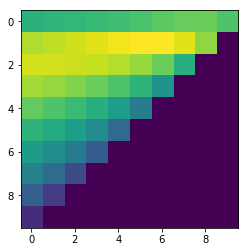

In [5]:
scoresa = np.array(scoresa)
plot = np.maximum(np.average(scoresa, axis=0)-0.75, 0)*25
plt.imshow(plot)
print(plot)

So based on above picture I can slightly limit my search:

In [6]:
scoresa = []
scoresg = []
scores1 = []
scores2 = []
scores3 = []
scores4 = []
scores5 = []
precision = 100
for i in trange(500):
    X_train, X_val, y_train, y_val = ttsplit(X_a, y_a, test_size = 0.2)
#    knc = KNeighborsClassifier(n_neighbors=100, weights='distance')       not everything worked well enough to make sense including it in the search
#    knc.fit(X_train, y_train)
#    pred1 = knc.predict_proba(X_val)[:,1]
#    scores1+=[roc_auc_score(y_val, pred1)]

    nbc = GaussianNB()
    nbc.fit(X_train, y_train)
    pred2 = nbc.predict_proba(X_val)[:,1]
    scores2+=[roc_auc_score(y_val, pred2)]
    
    lr = LogisticRegression(solver = 'liblinear', C = 0.1, penalty = 'l1')
    lr.fit(X_train, y_train)
    pred3 = lr.predict_proba(X_val)[:,1]
    scores3+=[roc_auc_score(y_val, pred3)]
    
#    ab = AdaBoostClassifier(base_estimator=None, n_estimators=3, learning_rate=1.0)
#    ab.fit(X_train, y_train)
#    pred4 = ab.predict_proba(X_val)[:,1]
#    scores4+=[roc_auc_score(y_val, pred4)]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    evallist = [ (dtrain, 'train'), (dval, 'eval')]
    bst1 = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10, verbose_eval = False)
    pred5 = bst1.predict(xgb.DMatrix(X_val), ntree_limit=bst1.best_ntree_limit)
    scores5+=[roc_auc_score(y_val, pred5)]
    
    generalA = np.zeros((precision,precision)) #all possible arithmetic means
    for j in range(0,20):
        for k in range(40,60):
            generalA[j,k] = ( roc_auc_score(y_val,( (pred2*j+pred5*k+pred3*(precision-j-k))/precision )))

    scoresa+=[generalA]
    

print(np.average(np.array(scores2)),np.average(np.array(scores5)),np.average(np.array(scores3)))

100%|██████████| 500/500 [03:26<00:00,  2.23it/s]

0.730274717859264 0.7449240687952038 0.788327592355937


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


0.80945555499377

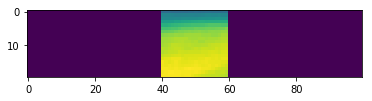

In [7]:
scoresa = np.array(scoresa)
print(scoresa[0:20,40:60])
plot = np.maximum(np.average(scoresa[40:60,0:20], axis=0)-0.75, 0)*25
plt.imshow(plot)

np.max(np.average(scoresa, axis = 0))

So something like 0.1, 0.55, 0.35 should be close enough

In [8]:
X_train, X_val, y_train, y_val = ttsplit(X_a, y_a, test_size = 0.2)
nbc = GaussianNB()
nbc.fit(X_a, y_a)
pred2 = nbc.predict_proba(X_test)[:,1]

lr = LogisticRegression(solver = 'liblinear', C = 0.1, penalty = 'l1')
lr.fit(X_a, y_a)
pred3 = lr.predict_proba(X_test)[:,1]

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
evallist = [ (dtrain, 'train'), (dval, 'eval')]
bst1 = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10, verbose_eval = False)
pred5 = bst1.predict(xgb.DMatrix(X_test), ntree_limit=bst1.best_ntree_limit)

pred = pred2*0.1+pred3*0.35+pred5*0.55


In [9]:
sub.target = pred
sub.to_csv('submission.csv', index=False)